In [3]:
import fly_plot_lib.plot as fpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import figurefirst as fifi
import seaborn as sns
from scipy import stats
# from statsmodels.stats import proportions_ztest

In [2]:
ms =4
lw= .5
fs =6

# Couple of helper functions

In [1181]:
#saccade frequency
def freq_from_sacc_df(df):
    freq_vec = []
    for i in df['obj_id_unique'].unique():
        s =df[df['obj_id_unique']==i]
        leng =s['max len'].iloc[0]/1000
        if leng >3-.68:
            leng= 3.-.68
        sacc_no =len(s)
        freq =sacc_no/leng
        freq_vec.append(freq)
    return freq_vec
#delayed 220 ms to capture only casting saccades
def freq_from_sacc_df_laminar_specific(df):
    freq_vec = []
    for i in df['obj_id_unique'].unique():
        s =df[df['obj_id_unique']==i]
        leng =s['max len'].iloc[0]/1000
        if leng >3-.68:
            leng= 3.-.68
        sacc_no =len(s)
        #calculate frequency startin at 900 ms (220ms +680)
        freq =sacc_no/(leng-.22)
        freq_vec.append(freq)
    return freq_vec
def bernoulli_ci(p,n):
    q=1-p
    root=p*q/n
    interval=1.96*root**0.5
    return interval
    ####Only handles 95% CI at the moment because Im lazy
def diffa(array):
    d = np.diff(array)
    d = np.hstack( (d[0], d) )
    return d

In [391]:
def get_continuous_chunks(array, array2=None, jump=1, return_index=False):
    """
    Splits array into a list of continuous chunks. Eg. [1,2,3,4,5,7,8,9] becomes [[1,2,3,4,5], [7,8,9]]
    
    array2  -- optional second array to split in the same way array is split
    jump    -- specifies size of jump in data to create a break point
    """
    diffarray = diffa(array)
    break_points = np.where(np.abs(diffarray) > jump)[0]
    break_points = np.insert(break_points, 0, 0)
    break_points = np.insert(break_points, len(break_points), len(array))
    
    chunks = []
    array2_chunks = []
    index = []
    for i, break_point in enumerate(break_points):
        if break_point >= len(array):
            break
        chunk = array[break_point:break_points[i+1]]
        if type(chunk) is not list:
            chunk = chunk.tolist()
        chunks.append(chunk)
        
        if array2 is not None:
            array2_chunk = array2[break_point:break_points[i+1]]
            if type(array2_chunk) is not list:
                array2_chunk = array2_chunk.tolist()
            array2_chunks.append(array2_chunk)
        
        if return_index:
            indices_for_chunk = np.arange(break_point,break_points[i+1])
            index.append(indices_for_chunk)
            
    if type(break_points) is not list:
        break_points = break_points.tolist()
        
    if return_index:
        return index
    
    if array2 is None:
        return chunks, break_points
    
    else:
        return chunks, array2_chunks, break_points

# Read in trajectory data sets and the mGSD score annotations

In [309]:
no_wind =pd.read_csv('../trimmed_data/main/Orco_CsChrimson_still_air_merged.csv')
nw_scores= pd.read_csv('../trimmed_data/mGSD_annotations/modified_GSD_no_wind_orco.csv')

In [310]:
l_w=pd.read_csv('../trimmed_data/main/OrcoCsChrimson_laminar_wind_merged.csv')
lw_scores=pd.read_csv('../trimmed_data/mGSD_annotations/modified_GSD_laminar_wind_orco.csv')

In [311]:
nw_merged= pd.merge(no_wind, nw_scores, on=['obj_id_unique', 'time stamp'])
lw_merged= pd.merge(l_w, lw_scores, on=['obj_id_unique', 'time stamp'])

# Read in the extracted saccades from each relevant data set

In [4]:
nw100_sacc=pd.read_csv('../trimmed_data/mGSD_annotations/nw100_orco_sacc.csv')
lw100_sacc=pd.read_csv('../trimmed_data/mGSD_annotations/lw100_orco_sacc.csv')
nw0_sacc=pd.read_csv('../trimmed_data/mGSD_annotations/nw0_orco_sacc.csv')
lw0_sacc=pd.read_csv('../trimmed_data/mGSD_annotations/lw0_orco_sacc.csv')
nw100_sacc_wt=pd.read_csv('../trimmed_data/mGSD_annotations/nw100_wt_sacc.csv')
nw0_sacc_wt=pd.read_csv('../trimmed_data/mGSD_annotations/nw0_wt_sacc.csv')
lw100_sacc_wt=pd.read_csv('../trimmed_data/mGSD_annotations/lw100_wt_sacc.csv')
lw0_sacc_wt=pd.read_csv('../trimmed_data/mGSD_annotations/lw0_wt_sacc.csv')

In [6]:
nw100_sacc['cond']="nw100"
lw100_sacc['cond']="lw100"
nw0_sacc['cond']="nw0"
lw0_sacc['cond']='lw0'

In [7]:
orco_saccs = pd.concat([nw100_sacc, lw100_sacc, nw0_sacc, lw0_sacc])

In [8]:
#include only saccades that occured after the pulse but in the 3 second window of interest
nw100_sacc=nw100_sacc[nw100_sacc['when'].between(680, 3000)]
nw0_sacc=nw0_sacc[nw0_sacc['when'].between(680, 3000)]
nw100_sacc_wt=nw100_sacc_wt[nw100_sacc_wt['when'].between(680, 3000)]
nw0_sacc_wt=nw0_sacc_wt[nw0_sacc_wt['when'].between(680, 3000)]
lw100_sacc=lw100_sacc[lw100_sacc['when'].between(900, 3000)]
lw0_sacc=lw0_sacc[lw0_sacc['when'].between(900, 3000)]
lw100_sacc_wt=lw100_sacc_wt[lw100_sacc_wt['when'].between(900, 3000)]
lw0_sacc_wt=lw0_sacc_wt[lw0_sacc_wt['when'].between(900, 3000)]

In [13]:
print(len(lw100_sacc_wt))
print(len(lw0_sacc))

1134
922


In [1184]:
#get frequency vectors
nw100_freq =freq_from_sacc_df(nw100_sacc)
nw0_freq =freq_from_sacc_df(nw0_sacc)
lw100_freq =freq_from_sacc_df_laminar_specific(lw100_sacc)
lw0_freq =freq_from_sacc_df_laminar_specific(lw0_sacc)
nw100_freq_wt =freq_from_sacc_df(nw100_sacc_wt)
nw0_freq_wt =freq_from_sacc_df(nw0_sacc_wt)
lw100_freq_wt =freq_from_sacc_df_laminar_specific(lw100_sacc_wt)
lw0_freq_wt= freq_from_sacc_df_laminar_specific(lw0_sacc_wt)

In [1280]:
#turn frequency vectors into np array
nw100_freq =np.array(nw100_freq)
nw0_freq=np.array(nw0_freq)
lw100_freq = np.array(lw100_freq)
lw0_freq = np.array(lw0_freq)
nw100_freq_wt=np.array(nw100_freq_wt)
nw0_freq_wt=np.array(nw0_freq_wt)
lw100_freq_wt=np.array(lw100_freq_wt)
lw0_freq_wt=np.array(lw0_freq_wt)

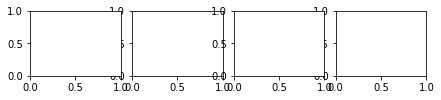

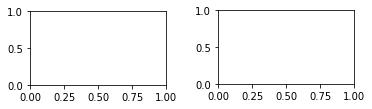

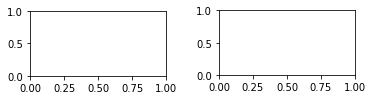

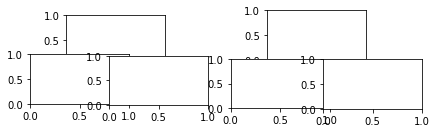

In [5]:
template = '../figure_first_templates/f3.svg'
layout =fifi.svg_to_axes.FigureLayout(template, autogenlayers=True, make_mplfigures=True, hide_layers=[])

In [2036]:
threshold = 0.001

In [2037]:
nw_merged['score']=nw_merged['amp']*nw_merged['disp']
lw_merged['score']=lw_merged['amp']*lw_merged['disp']

In [2038]:


lw1='290_20220927_170437'
lw2 = '6522_20220926_173927'
lw3 ='5962_20220926_173927'
nw1 ='2440_20220813_165621'
nw2 ='4460_20220813_165621'
nw3 ='11565_20220813_165621'

lt1 =lw_merged[lw_merged['obj_id_unique']==lw1]
lt2 = lw_merged[lw_merged['obj_id_unique']==lw2]
lt3 = lw_merged[lw_merged['obj_id_unique']==lw3]
nt1= nw_merged[nw_merged['obj_id_unique']==nw1]
nt2 = nw_merged[nw_merged['obj_id_unique']==nw2]
nt3 = nw_merged[nw_merged['obj_id_unique']==nw3]

In [2039]:
ax=layout.axes[('traj', 'nw1')]

In [2040]:
pre = nt2[nt2['time stamp'].between(-100, 0)]
dur = nt2[nt2['time stamp'].between(0, 680)]
post = nt2[nt2['time stamp'].between(680, 5000)]
sac_sub = nw100_sacc[nw100_sacc['obj_id_unique']==nw2]
#print(sac_sub)
ax.plot(pre['x'], pre['y'], color = 'k', linewidth =.75)
ax.plot(dur['x'], dur['y'], color = 'red', linewidth = .75)
ax.plot(post['x'], post['y'], color = 'k', linewidth = .75)
ax.set_xlim(-.5, .5)
ax.set_ylim(-.25, .25)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
candidate_saccades = np.where(post['score']>threshold)[0]

chunks, breaks = get_continuous_chunks(candidate_saccades, jump=4)
saccade_locations = []
for chunk in chunks:
    if len(chunk)>0:
        saccade_locations.append(np.median(chunk).astype(int))
saccade_locations = np.array(saccade_locations)
for j in saccade_locations:
    ax.scatter(post['x'].iloc[j], post['y'].iloc[j],  s =10, color = 'blue',linewidth = .5,alpha = 0.9,  facecolors ='none')


In [2041]:
ax=layout.axes[('traj', 'nw2')]

In [2042]:
pre = nt1[nt1['time stamp'].between(-100, 0)]
dur = nt1[nt1['time stamp'].between(0, 680)]
post = nt1[nt1['time stamp'].between(680, 5000)]

#print(sac_sub)
ax.plot(pre['x'], pre['y'], color = 'k', linewidth =.75 )
ax.plot(dur['x'], dur['y'], color = 'red', linewidth = .75)
ax.plot(post['x'], post['y'], color = 'k', linewidth = .75)
ax.set_xlim(-.5, .5)
ax.set_ylim(-.25, .25)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
candidate_saccades = np.where(post['score']>threshold)[0]
try:
        chunks, breaks = get_continuous_chunks(candidate_saccades, jump=4)
        saccade_locations = []
        for chunk in chunks:
            if len(chunk)>0:
                saccade_locations.append(np.median(chunk).astype(int))
        saccade_locations = np.array(saccade_locations)
        for j in saccade_locations:
            ax.scatter(post['x'].iloc[j], post['y'].iloc[j],  s =10, color = 'blue',alpha = 0.9, linewidth = .5, facecolors ='none')
except:
    pass

In [2043]:
ax=layout.axes[('traj', 'nw3')]

In [2044]:
pre = nt3[nt3['time stamp'].between(-100, 0)]
dur = nt3[nt3['time stamp'].between(0, 680)]
post = nt3[nt3['time stamp'].between(680, 5000)]

#print(sac_sub)
ax.plot(pre['x'], pre['y'], color = 'k', linewidth =.75)
ax.plot(dur['x'], dur['y'], color = 'red', linewidth = .75)
ax.plot(post['x'], post['y'], color = 'k', linewidth = .75)
ax.set_xlim(-.5, .5)
ax.set_ylim(-.25, .25)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
candidate_saccades = np.where(post['score']>threshold)[0]
try:
        chunks, breaks = get_continuous_chunks(candidate_saccades, jump=4)
        saccade_locations = []
        for chunk in chunks:
            if len(chunk)>0:
                saccade_locations.append(np.median(chunk).astype(int))
        saccade_locations = np.array(saccade_locations)
        for j in saccade_locations:
            ax.scatter(post['x'].iloc[j], post['y'].iloc[j],  s =10, color = 'blue', alpha = 0.9, linewidth = .5, facecolors ='none')
except:
    pass

In [2045]:
ax=layout.axes[('traj', 'lw1')]

In [2046]:
pre = lt1[lt1['time stamp'].between(-100, 0)]
dur = lt1[lt1['time stamp'].between(0, 680)]
post = lt1[lt1['time stamp'].between(680, 5000)]

#print(sac_sub)
ax.plot(pre['x'], pre['y'], color = 'k', linewidth =.75)
ax.plot(dur['x'], dur['y'], color = 'red', linewidth = .75)
ax.plot(post['x'], post['y'], color = 'k', linewidth = .75)
ax.set_xlim(-.5, .5)
ax.set_ylim(-.25, .25)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
candidate_saccades = np.where(post['score']>threshold)[0]
try:
        chunks, breaks = get_continuous_chunks(candidate_saccades, jump=4)
        saccade_locations = []
        for chunk in chunks:
            if len(chunk)>0:
                saccade_locations.append(np.median(chunk).astype(int))
        saccade_locations = np.array(saccade_locations)
        for j in saccade_locations:
            ax.scatter(post['x'].iloc[j], post['y'].iloc[j],  s =10, color = 'orange', linewidth = .5, alpha = 0.9, facecolors ='none')
except:
    pass

In [2047]:
ax=layout.axes[('traj', 'lw2')]

In [2048]:
pre = lt2[lt2['time stamp'].between(-100, 0)]
dur = lt2[lt2['time stamp'].between(0, 680)]
post = lt2[lt2['time stamp'].between(680, 5000)]

#print(sac_sub)
ax.plot(pre['x'], pre['y'], color = 'k', linewidth =.75)
ax.plot(dur['x'], dur['y'], color = 'red', linewidth = .75)
ax.plot(post['x'], post['y'], color = 'k', linewidth = .75)
ax.set_xlim(-.5, .5)
ax.set_ylim(-.25, .25)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
candidate_saccades = np.where(post['score']>threshold)[0]
try:
        chunks, breaks = get_continuous_chunks(candidate_saccades, jump=4)
        saccade_locations = []
        for chunk in chunks:
            if len(chunk)>0:
                saccade_locations.append(np.median(chunk).astype(int))
        saccade_locations = np.array(saccade_locations)
        for j in saccade_locations:
            ax.scatter(post['x'].iloc[j], post['y'].iloc[j],  s =10, color = 'orange', linewidth = .5, alpha = 0.9, facecolors ='none')
except:
    pass

In [2049]:
ax=layout.axes[('traj', 'lw3')]

In [2050]:
pre = lt3[lt3['time stamp'].between(-100, 0)]
dur = lt3[lt3['time stamp'].between(0, 680)]
post = lt3[lt3['time stamp'].between(680, 5000)]

#print(sac_sub)
ax.plot(pre['x'], pre['y'], color = 'k', linewidth =.75)
ax.plot(dur['x'], dur['y'], color = 'red', linewidth = .75)
ax.plot(post['x'], post['y'], color = 'k', linewidth = .75)
ax.set_xlim(-.5, .5)
ax.set_ylim(-.25, .25)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_xticks([])
ax.set_yticks([])
candidate_saccades = np.where(post['score']>threshold)[0]
try:
        chunks, breaks = get_continuous_chunks(candidate_saccades, jump=4)
        saccade_locations = []
        for chunk in chunks:
            if len(chunk)>0:
                saccade_locations.append(np.median(chunk).astype(int))
        saccade_locations = np.array(saccade_locations)
        for j in saccade_locations:
            ax.scatter(post['x'].iloc[j], post['y'].iloc[j],  s =10, color = 'orange', linewidth = .9, alpha = 0.5, facecolors ='none')
except:
    pass

# Amplitude Distributions of Orco>CsChrimson flies which recieved a flash event

In [2051]:
ax=layout.axes[('amp', 'oroc_f')]

In [2052]:
sns.distplot(nw100_sacc['amp'], color = 'blue', ax = ax, kde_kws=dict(linewidth=lw))
sns.distplot(lw100_sacc['amp'], color = 'orange', ax = ax, kde_kws=dict(linewidth=lw))
ax.axvline(x = nw100_sacc['amp'].mean(), color ='blue')
ax.axvline(x = lw100_sacc['amp'].mean(), color ='orange')
ax.set_xlim(0, 180)
fifi.mpl_functions.adjust_spines(ax,['bottom'], xticks =[0, 180], tick_length=3, linewidth=lw)
ax.set_xticklabels([])
ax.set_xlabel("")

Text(0.5,3.2,'')

# Sham event

In [2053]:
ax=layout.axes[('amp', 'oroc_s')]

In [2054]:
sns.distplot(nw0_sacc['amp'], color = 'blue', ax = ax, kde_kws=dict(linewidth=lw))
sns.distplot(lw0_sacc['amp'], color = 'orange', ax = ax, kde_kws=dict(linewidth=lw))
fifi.mpl_functions.adjust_spines(ax,['bottom'], xticks =[0, 180], tick_length=3, linewidth=lw)
#ax.axvline(x = nw0_sacc['amp'].mean(), color ='blue', linewidth = lw)
#ax.axvline(x = lw0_sacc['amp'].mean(), color ='orange')
ax.set_xlim(0, 180)
fifi.mpl_functions.adjust_spines(ax,['bottom'], xticks =[0, 180], tick_length=3, linewidth=.75)
ax.set_xticklabels([])
ax.set_xlabel("")

Text(0.5,3.2,'')

# Wild Type Control Flash event

In [2055]:
ax=layout.axes[('amp', 'wt_f')]

In [2056]:
sns.distplot(nw100_sacc_wt['amp'], color = 'blue', ax = ax, kde_kws=dict(linewidth=lw))
sns.distplot(lw100_sacc_wt['amp'], color = 'orange', ax = ax, kde_kws=dict(linewidth=lw))
#ax.axvline(x = nw100_sacc_wt['amp'].mean(), color ='blue')
#ax.axvline(x = lw100_sacc_wt['amp'].mean(), color ='orange')
ax.set_xlim(0, 180)
fifi.mpl_functions.adjust_spines(ax,['bottom'], xticks =[0, 180], tick_length=3, linewidth=.75)
ax.set_xticklabels([])
ax.set_xlabel("")

Text(0.5,3.2,'')

# Wild Type Control Sham Event

In [2057]:
ax=layout.axes[('amp', 'wt_s')]

In [2058]:
sns.distplot(nw0_sacc_wt['amp'], color = 'blue', ax = ax, kde_kws=dict(linewidth=lw))
sns.distplot(lw0_sacc_wt['amp'], color = 'orange', ax = ax, kde_kws=dict(linewidth=lw))
fifi.mpl_functions.adjust_spines(ax,['bottom'], xticks =[0, 180], tick_length=3, linewidth=lw)
#ax.axvline(x = nw0_sacc_wt['amp'].mean(), color ='blue')
#ax.axvline(x = lw0_sacc_wt['amp'].mean(), color ='orange')
ax.set_xlim(0, 180)
fifi.mpl_functions.adjust_spines(ax,['bottom'], xticks =[0, 180], tick_length=3, linewidth=.75)
ax.set_xticklabels([])
ax.set_xlabel("")

Text(0.5,3.2,'')

# Frequency Plots

In [2059]:
ax=layout.axes[('freq', 'oroc_f')]

In [2061]:
ordo=[-1., 0., 1., 2.]
bins = [ nw100_freq, lw100_freq, nw0_freq,  lw0_freq]
labs = [ "",  "",'', '']
colors = [ 'blue', 'orange' ,'blue', 'orange']
xwidth=.25
for i in range(len(bins)):
    u=ordo[i]+.2
    l=ordo[i]-.2
    m=means[i]
    ax.plot([l, u],[m, m], color = colors[i], linewidth=.75 )
    ax.fill_between([l-.021, u+.021], [m+cis[i], m+cis[i]], [m-cis[i], m-cis[i]], color = colors[i], alpha = 0.2, linewidth=0)
    fpl.scatter_box(ax, i-1, bins[i], color=colors[i], xwidth=0.25, markersize=.4,marker_linewidth=0,alpha=.1, shading = 'none')


ax.set_ylim(0, 6)

fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],xticks=[0, 1, 2, 3, 4], yticks=[0, 6], tick_length=3, linewidth=.75)

ax.set_xticklabels([])

fifi.mpl_functions.set_fontsize(ax, fs)

In [2062]:
ax=layout.axes[('freq', 'wt_f')]

In [2063]:
ordo=[-1., 0., 1., 2.]
bins = [ nw100_freq_wt, lw100_freq_wt, nw0_freq_wt,  lw0_freq_wt]
labs = [ "",  "",'', '']
colors = [ 'blue', 'orange' ,'blue', 'orange']
xwidth=.25
for i in range(len(bins)):
    u=ordo[i]+.2
    l=ordo[i]-.2
    m=means_wt[i]
    ax.plot([l, u],[m, m], color = colors[i], linewidth = .75 )
    ax.fill_between([l-.021, u+.021], [m+cis_wt[i], m+cis_wt[i]], [m-cis_wt[i], m-cis_wt[i]], color = colors[i], alpha = 0.2, linewidth =0)
    fpl.scatter_box(ax, i-1, bins[i], color=colors[i], xwidth=0.25, markersize=.35,marker_linewidth=0,alpha=.1, shading = 'none')

ax.set_ylim(0, 6)

fifi.mpl_functions.adjust_spines(ax, ['left', 'bottom'],xticks=[0, 1, 2, 3, 4], yticks=[0, 6], tick_length=3, linewidth=.75)

ax.set_xticklabels(labs)

fifi.mpl_functions.set_fontsize(ax, fs)

In [2091]:
ordo=[0, 1, 2, 3]
print("no wind flash mean = " +str(np.mean(nw100_freq)))
print("laminar wind flash mean = " +str(np.mean(lw100_freq)))
print("no wind sham mean = " +str(np.mean(nw0_freq)))
print("no wind sham mean = " +str(np.mean(lw0_freq)))
print("\n")
print("no wind flash 95%CI = " +str(1.96*stats.sem(nw100_freq)))
print("laminar wind flash 95%CI = " +str(1.96*stats.sem(lw100_freq)))
print("no wind sham mean 95%CI = " +str(1.96*stats.sem(nw0_freq)))
print("no wind sham mean 95%CI= " +str(1.96*stats.sem(lw0_freq)))
print("\n")
print("no wind flash STD = " +str(np.std(nw100_freq)))
print("laminar wind flash sTD = " +str(np.std(lw100_freq)))
print("no wind sham mean std = " +str(np.std(nw0_freq)))
print("no wind sham mean std= " +str(np.std(lw0_freq)))

means =[3.38, 2.89, 2.47, 2.42]
cis=[.116, .125, .121, .134]
ordo=[-1., 0., 1., 2.]

no wind flash mean = 3.38155644861176
laminar wind flash mean = 2.8941968753362826
no wind sham mean = 2.477847664630519
no wind sham mean = 2.4224100450896375


no wind flash 95%CI = 0.11596683239406237
laminar wind flash 95%CI = 0.1252738928682864
no wind sham mean 95%CI = 0.12136582124575111
no wind sham mean 95%CI= 0.13425614439271588


no wind flash STD = 0.9540351969537434
laminar wind flash sTD = 0.9650991328749059
no wind sham mean std = 1.0416781279012934
no wind sham mean std= 0.9926308004518645


In [2093]:
ordo=[0, 1, 2, 3]
print("no wind wt flash mean = " +str(np.mean(nw100_freq_wt)))
print("laminar wind flash mean = " +str(np.mean(lw100_freq_wt)))
print("no wind sham mean = " +str(np.mean(nw0_freq_wt)))
print("no wind sham mean = " +str(np.mean(lw0_freq_wt)))
print("\n")
print("no wind flash 95%CI = " +str(1.96*stats.sem(nw100_freq_wt)))
print("laminar wind flash 95%CI = " +str(1.96*stats.sem(lw100_freq_wt)))
print("no wind sham mean 95%CI = " +str(1.96*stats.sem(nw0_freq_wt)))
print("no wind sham mean 95%CI= " +str(1.96*stats.sem(lw0_freq_wt)))
print("\n")
print("no wind flash STD = " +str(np.std(nw100_freq_wt)))
print("laminar wind flash sTD = " +str(np.std(lw100_freq_wt)))
print("no wind sham mean std = " +str(np.std(nw0_freq_wt)))
print("no wind sham mean std= " +str(np.std(lw0_freq_wt)))
means_wt =[1.945, 1.944, 1.806, 2.19]
cis_wt=[.153, .121, .142, .125]
ordo=[-1., 0., 1., 2.]

no wind wt flash mean = 1.94580090501253
laminar wind flash mean = 1.94441757570517
no wind sham mean = 1.8064201270594782
no wind sham mean = 2.1950797064130625


no wind flash 95%CI = 0.153527806452417
laminar wind flash 95%CI = 0.12179212956915073
no wind sham mean 95%CI = 0.14226023857368414
no wind sham mean 95%CI= 0.12520543463383654


no wind flash STD = 1.0421197023319642
laminar wind flash sTD = 1.1390237812255155
no wind sham mean std = 0.9519007845912958
no wind sham mean std= 1.2086724473145414


# Ipsilateral vs Contralateral Plots

In [2073]:
ax=layout.axes[('ipsi','ipsi', 'orco')]

In [2075]:
orco_m=[.75, 1-0.75,.538, 1-0.538, 0.555, 1-0.555,0.566, 1-0.566 ]
orco_ci =[.019, 0.019, 0.027, .027, 0.0258, 0.0258,  0.0307, 0.0307]

In [2076]:
colors = ['blue', 'blue', 'orange', 'orange', 'blue', 'blue', 'orange', 'orange']
ordo=[0, 1, 2, 3, 4, 5, 6, 7]

In [2077]:
ax.axhline(y=0.5, color = 'k', linestyle = '--', linewidth =lw, alpha = 0.8)
for i in range(len(ordo)):
    u=ordo[i]+.3
    l=ordo[i]-.3
    m=orco_m[i]
    ax.plot([l+.031, u-.031],[m, m], color = colors[i], linewidth=lw )
    ax.fill_between([l, u], [m+orco_ci[i], m+orco_ci[i]], [m-orco_ci[i], m-orco_ci[i]], color = colors[i], alpha = 0.2, linewidth =0)

ax.spines['right'].set_visible(False)
ax.spines['top']. set_visible(False)
ax.set_xticklabels([])

ax.set_ylim(0, 1.0)
ax.set_yticklabels([0,'', 1])
fifi.mpl_functions.adjust_spines(ax,['bottom', 'left'], xticks =[0, 1, 2, 3, 4, 5, 6, 7], yticks=[0,.5, 1],  tick_length=3, linewidth=.75)
fifi.mpl_functions.set_fontsize(ax, fs)

In [2078]:
ax=layout.axes[('ipsi','ipsi', 'wt')]

In [2079]:
wt_m=[.557, 1-.557, 0.527, 1-0.527, .510, 1-.510, 0.497, 1-0.497]
wt_ci=[ 0.038, 0.038, 0.028, 0.028,0.039, 0.039, 0.0265, 0.0265 ]

In [2080]:
ax.axhline(y=0.5, color = 'k', linestyle = '--', linewidth =lw, alpha = 0.8)
for i in range(len(ordo)):
    u=ordo[i]+.3
    l=ordo[i]-.3
    m=wt_m[i]
    ax.plot([l+.031, u-.031],[m, m], color = colors[i], linewidth=lw )
    ax.fill_between([l, u], [m+wt_ci[i], m+wt_ci[i]], [m-wt_ci[i], m-wt_ci[i]], color = colors[i], alpha = 0.2, linewidth =0)

ax.spines['right'].set_visible(False)
ax.spines['top']. set_visible(False)
ax.set_xticklabels([])

ax.set_ylim(0, 1.0)
ax.set_yticklabels([0,'', 1])
fifi.mpl_functions.adjust_spines(ax,['bottom', 'left'], xticks =[0, 1, 2, 3, 4, 5, 6, 7], yticks=[0,.5, 1],  tick_length=3, linewidth=.75)
fifi.mpl_functions.set_fontsize(ax, fs)

# Save everything onto the FigureFirst Template svg

In [2081]:
layout.append_figure_to_layer(layout.figures['amp'], 'amp', cleartarget=True)
layout.append_figure_to_layer(layout.figures['freq'], 'freq', cleartarget=True)
layout.append_figure_to_layer(layout.figures['ipsi'], 'ipsi', cleartarget=True)
layout.append_figure_to_layer(layout.figures['traj'], 'traj', cleartarget=True)
layout.write_svg(template)

In [ ]:
def bernoulli_ci(p,n):
    q=1-p
    root=p*q/n
    interval=1.96*root**0.5
    return interval
    ####Only handles 95% CI at the moment because Im lazy
def get_binomial_zscore(p1, p2, n1, n2):
    p_hat = (n1*p1+n2*p2)/(n1+n2)
    nom=p1-p2
    denom=(p_hat*(1-p_hat))*(1/n1 + 1/n2)
    root_denom =denom **0.5
    z=nom/root_denom
    return z

In [2034]:
#####
#getting ipsilateral / contralateral probabilities 0 is an ipsilateral turn otherwise its a contralateral
####
print("No wind orco flash")
print(nw100_sacc['ipsi'].value_counts())
print("No wind orco sham")
print(nw0_sacc['ipsi'].value_counts())
print("Laminar wind orco flash")
print(lw100_sacc['ipsi'].value_counts())
print("Laminar wind orco sham")
print(lw0_sacc['ipsi'].value_counts())

No wind orco flash
 0.0    1416
 2.0     236
-2.0     235
Name: ipsi, dtype: int64
No wind orco sham
 0.0    789
 2.0    317
-2.0    314
Name: ipsi, dtype: int64
Laminar wind orco flash
 0.0    673
 2.0    278
-2.0    274
Name: ipsi, dtype: int64
Laminar wind orco sham
 0.0    519
-2.0    198
 2.0    195
Name: ipsi, dtype: int64


In [1938]:
######
#Same for WT subset
######
print("No wind wt flash")
print(nw100_sacc_wt['ipsi'].value_counts())
print("No wind wt sham")
print(nw0_sacc_wt['ipsi'].value_counts())
print("Laminar wt flash")
print(lw100_sacc_wt['ipsi'].value_counts())
print("Laminar wt sham")
print(lw0_sacc_wt['ipsi'].value_counts())

No wind wt flash
 0.0    361
-2.0    147
 2.0    140
Name: ipsi, dtype: int64
No wind wt sham
 0.0    308
-2.0    149
 2.0    146
Name: ipsi, dtype: int64
Laminar wt flash
 0.0    564
-2.0    253
 2.0    246
Name: ipsi, dtype: int64
Laminar wt sham
 0.0    641
 2.0    329
-2.0    315
Name: ipsi, dtype: int64


In [1699]:
nw100_ipsi=1416./(1416+235+236)
print("NW Orco Flash ipsi = " +  str(nw100_ipsi))
print("NW Orco flash bernoulli ci = " +str(bernoulli_ci(nw100_ipsi, (1416.+236+235))))

NW Orco Flash ipsi = 0.75039745628
NW Orco flash bernoulli ci = 0.0195272147015


In [1700]:
lw100_ipsi=704./(704+304+299)
print("LW Orco Flash ipsi = " +  str(lw100_ipsi))
print("LW Orco flash bernoulli ci = " +str(bernoulli_ci(lw100_ipsi, (704+304+299))))

LW Orco Flash ipsi = 0.538638102525
LW Orco flash bernoulli ci = 0.0270263673565


In [1701]:
nw0_ipsi=789./(789+317+314)
print("NW Orco sham ipsi = " +  str(nw0_ipsi))
print("NW Orco sham bernoulli ci = " +str(bernoulli_ci(nw0_ipsi, (789.+317+314))))

NW Orco sham ipsi = 0.555633802817
NW Orco sham bernoulli ci = 0.0258450118726


In [1702]:
lw0_ipsi=566./(566+218+216)
print("LW Orco sham ipsi = " +  str(lw0_ipsi))
print("LW Orco sham bernoulli ci = " +str(bernoulli_ci(lw0_ipsi, (566.+218+216))))

LW Orco sham ipsi = 0.566
LW Orco sham bernoulli ci = 0.0307191469673


In [1703]:
nw100_ipsi_wt=361./(361.+147+140)
print("NW WT Flash ipsi = " +  str(nw100_ipsi_wt))
print("NW WT flash bernoulli ci = " +str(bernoulli_ci(nw100_ipsi_wt, (361+147+140))))

NW WT Flash ipsi = 0.557098765432
NW WT flash bernoulli ci = 0.0382461841588


In [1704]:
lw100_ipsi_wt=627./(283.+627+279)
print("LW WT Flash ipsi = " +  str(lw100_ipsi_wt))
print("LW WT flash bernoulli ci = " +str(bernoulli_ci(lw100_ipsi_wt, (627.+283+279))))

LW WT Flash ipsi = 0.527333894029
LW WT flash bernoulli ci = 0.0283782243394


In [1705]:
nw0_ipsi_wt=308./(308.+149 +146)
print("NW WT sham ipsi = " +  str(nw0_ipsi_wt))
print("NW WT sham bernoulli ci = " +str(bernoulli_ci(nw100_ipsi_wt, (308. + 149+146))))

NW WT sham ipsi = 0.510779436153
NW WT sham bernoulli ci = 0.0396476050725


In [1706]:
lw0_ipsi_wt=698./(698.+360+344)
print("LW WT Sham ipsi = " +  str(lw0_ipsi_wt))
print("LW WT Sham bernoulli ci = " +str(bernoulli_ci(lw0_ipsi_wt, (698.+360+304))))

LW WT Sham ipsi = 0.497860199715
LW WT Sham bernoulli ci = 0.0265542197422
